In [1]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict, Counter
import mysql.connector
import sql

SQL_PASS = 'mango'
RSA_KEY = "/Users/averytandon/.ssh/rsa_key"
# SSM related modules
#import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)
#import ssm
#from ssm.util import find_permutation
#from ssm.plots import gradient_cmap, white_to_color_cmap
import seaborn as sns

In [2]:
# Query db_emorep and read in the dot products (emotion scores) 
# of emotion map and resting state fMRI data
db_con = sql._DbConnect()
db_con.con_server()

query = """

select 
a.subj_id, a.fsl_task_id,  a.volume,
    a.emo_amusement, a.emo_anger, a.emo_anxiety, a.emo_awe, a.emo_calmness,
    a.emo_craving, a.emo_disgust, a.emo_excitement, a.emo_fear, a.emo_horror,
    a.emo_joy, a.emo_neutral, a.emo_romance, a.emo_sadness, a.emo_surprise,
    a.label_max
from tbl_dotprod_emorep a  
join ref_sess_task b on a.subj_id=b.subj_id and a.sess_id=b.sess_id 
where a.fsl_task_id=1 and b.task_id=1

"""  

with db_con.con_cursor() as cur:
    cur.execute(query)
    query_results = cur.fetchall()

# Close the connection to the data base
db_con.con_close()

In [3]:
# %% convert query_results into a pandas dataframe
emo_rest = pd.DataFrame(
    query_results, columns=['subj_id', 'fsl_task_id', 'volume',
                         'emo_amusement', 'emo_anger', 'emo_anxiety', 
                         'emo_awe',   'emo_calmness','emo_craving', 
                         'emo_disgust','emo_excitement', 'emo_fear', 
                         'emo_horror', 'emo_joy', 'emo_neutral',
                         'emo_romance', 'emo_sadness', 'emo_surprise', 'label_max'])

# print(emo_rest.head())

In [4]:
# Concatenate emotion scores across subjects and get max emotion and label per volume
emo_scores=emo_rest.drop(['subj_id','fsl_task_id','label_max'], index=None,axis=1)
column_names = ['emo_amusement', 'emo_anger', 'emo_anxiety', 
                         'emo_awe',   'emo_calmness','emo_craving', 
                         'emo_disgust','emo_excitement', 'emo_fear', 
                         'emo_horror', 'emo_joy', 'emo_neutral',
                         'emo_romance', 'emo_sadness', 'emo_surprise']

total_scores = emo_scores.groupby('volume').mean()
total_scores['emo_max'] = emo_scores[['emo_amusement', 'emo_anger', 'emo_anxiety', \
                         'emo_awe',   'emo_calmness','emo_craving', \
                         'emo_disgust','emo_excitement', 'emo_fear', \
                         'emo_horror', 'emo_joy', 'emo_neutral', \
                         'emo_romance', 'emo_sadness', 'emo_surprise']].idxmax(axis=1)
total_scores['label_max'] = total_scores.columns.get_indexer(total_scores['emo_max']) + 1

In [5]:
# Define Color Map
color_map = {
    1: "gold", #amusement
    2: "red", #anger
    3: "purple", #anxiety
    4: "orange", #awe
    5: "limegreen", #calmness
    6: "orangered", #craving
    7: "lawngreen", #disgust
    8: "hotpink", #excitement
    9: "black", #fear
    10: "saddlebrown", #horror
    11: "yellow", #joy
    12: "silver", #neutral
    13: "violet", #romance
    14: "blue", #sadness
    15: "cyan" #surprise
}

In [13]:
# Create dictionary of each subject's emotion sequences
emo_seqs = emo_rest.groupby('subj_id')['label_max'].apply(list).to_dict()

In [6]:
def color_sequences(seqs, map):
    # Create a dictionary to store each subj's color sequences
    color_seqs = {}
    for subj_id, seq in seqs.items():
        # Map the numbers to colors using the color map
        color_seqs[subj_id] = [map.get(num, 'black') for num in seq]
    return color_seqs

def total_color_sequence(seqs, map):
    # Create concatenated color sequence
    total_color_seq = []
    for num in seqs['label_max']:
        total_color_seq.append(map.get(num))
    return total_color_seq

def plot_seqs(seqs):
    # Plot first 10 individual's color sequences
    fig, ax = plt.subplots(figsize=(10, 10))
    gap = 1  # Gap between each subject's color sequence

    first_10_subjects = list(seqs.items())[:10]

    for i, (subj_id, colors) in enumerate(first_10_subjects):
        for j, color in enumerate(colors):
            ax.barh(i * (gap + 1), 1, left=j, color=color, edgecolor='k')
        
        # Add the subject ID as a label
        ax.text(-1, i * (gap + 1), f"Subj {subj_id}", va='center', ha='right', fontsize=10)

    ax.set_yticks([i * (gap + 1) for i in range(len(first_10_subjects))])
    ax.set_yticklabels([])
    ax.set_xlabel("Position in Sequence")
    ax.set_title("Color Sequences for First 10 Subjects")
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_total_seq(seq):
    # Plot concatenated color sequence
    fig, ax = plt.subplots(figsize=(10, 2))

    # Plot the color sequence
    for j, color in enumerate(seq):
        ax.barh(0, 1, left=j, color=color, edgecolor='k')

    # Formatting the plot
    ax.set_yticks([])  # Remove the y-axis ticks
    ax.set_xlabel("Volume")
    ax.set_title("Classification Sequence Across Subjects")
    # Set the x-axis limit based on the length of the color sequence
    ax.set_xlim(0, len(seq)) 

    # Show the plot
    plt.tight_layout()
    plt.show()

In [8]:
def transition_matrix(sequences):
    # Create transition matrix
    n = 15 #number of states
    M = np.zeros((n, n), dtype=float)

    for seq in sequences:
        for i, j in zip(seq, seq[1:]):
            if 0 <= i < n and 0 <= j < n: M[i][j] += 1

    # Now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

def get_total_tm(seqs):
    # Get total TM
    adj_emo_seqs = {key: [value - 1 for value in values if value > 0] for key, values in seqs.items()}
    tm = transition_matrix(adj_emo_seqs.values())
    # Create a mask to threshold transition probabilities
    threshold = 0.05
    masked_tm = np.ma.masked_where(tm < threshold, tm)
    return masked_tm

def get_indiv_tms(seqs):
    # Get individual TM's
    tms = {}
    for subj_id, seq in seqs.items():
        adj_seq = [s - 1 for s in seq if s > 0]
        tms[subj_id] = transition_matrix([adj_seq])
    return tms

In [9]:
def plot_tm(tm, cols):
    # Plot Transition Matrix
    # Create a mask to threshold transition probabilities
    threshold = 0.05 
    tm = np.ma.masked_where(tm < threshold, tm)

    # Define a colormap for values above the threshold
    cmap = plt.cm.plasma
    tpm_colors = cmap(np.arange(cmap.N))
    tpm_colors[0] = (1, 1, 1, 0.0)  # Set color for values below the threshold (transparent white)

    new_cmap = LinearSegmentedColormap.from_list('truncated_cmap', tpm_colors)

    # Visualize the thresholded transition probability matrix
    plt.figure(figsize=(24, 16))
    plt.imshow(tm, cmap=new_cmap, interpolation='nearest')
    cbar = plt.colorbar()
    cbar.set_label('Transition Probability', fontsize=30)
    cbar.ax.tick_params(labelsize=25)

    emo_labels=[]
    for column_name in cols:
        emo_label=column_name.split("_")[1]
        emo_labels.append(emo_label)
    num_states = 15

    plt.title('Transition Probability Matrix',fontsize=40)
    plt.xlabel('Next State',fontsize=35)
    plt.ylabel('Current State',fontsize=35)
    plt.xticks(np.arange(num_states), emo_labels,fontsize=35,rotation=90)
    plt.yticks(np.arange(num_states), emo_labels,fontsize=35)
    plt.tight_layout()
    plt.show()

In [10]:
def calc_emo_reset(seqs):
    # Calculate emotional resetting
    neutral_idx = 11
    emo_reset = {}
    for sub, x in seqs.items():
        count = 0
        for i in range(len(x)):
            if (i+1) < len(x):
                if x[i+1]==neutral_idx:
                    if x[i]!=11: count += 1
        emo_reset[sub] = count / 239
    return emo_reset

def plot_emo_reset(emo_reset):
    # Plot emotional resetting
    # subjs = list(emo_reset.keys())
    resets = np.array(list(emo_reset.values()))

    median = np.median(resets)
    q1 = np.percentile(resets, 25)
    q3 = np.percentile(resets, 75)
    x = np.random.normal(1, 0.05, size=len(resets))

    plt.figure(figsize=(4, 6))
    plt.scatter(x, resets, color='skyblue')
    plt.axhline(y=median, color='red', linestyle='--', linewidth=2, label=f'Median ({median:.2f})')
    plt.axhline(y=q1, color='orange', linestyle=':', linewidth=1.5, label=f'Q1 ({q1:.2f})')
    plt.axhline(y=q3, color='orange', linestyle=':', linewidth=1.5, label=f'Q3 ({q3:.2f})')

    # plt.xlabel("Subject ID")
    plt.ylabel("Probability of Transitioning to Neutral")
    plt.title("Emotional Resetting")
    plt.xticks([1], ["Emotional Resetting"])
    # plt.xticks(subjs, rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
def calc_inertia(seqs):
    # Calculate inertia
    emo_inertia = {}
    for sub, seq in seqs.items():
        count = 0
        for i in range(len(seq)):
            if (i+1) < len(seq):
                if seq[i] == seq[i+1]:
                    if seq[i]!=11: count += 1
        emo_inertia[sub] = count / 240
    return emo_inertia

def plot_inertia(emo_inertia):
    # Plot emotional inertia values
    # subjs = list(emo_inertia.keys())
    inertia = np.array(list(emo_inertia.values()))

    median = np.median(inertia)
    q1 = np.percentile(inertia, 25)
    q3 = np.percentile(inertia, 75)
    x = np.random.normal(1, 0.05, size=len(inertia))

    plt.figure(figsize=(4, 6))
    plt.scatter(x, inertia, color='skyblue', label='Emotional Inertia', alpha=0.7)
    plt.axhline(y=median, color='red', linestyle='--', linewidth=2, label=f'Median ({median:.2f})')
    plt.axhline(y=q1, color='orange', linestyle=':', linewidth=1.5, label=f'Q1 ({q1:.2f})')
    plt.axhline(y=q3, color='orange', linestyle=':', linewidth=1.5, label=f'Q3 ({q3:.2f})')
    
    # plt.scatter(subjs, resets, color='skyblue')
    # plt.xlabel("Subject ID")
    plt.ylabel("Probability of Staying in the Same State")
    plt.title("Emotional Inertia")
    plt.xticks([1], ["Emotional Inertia"])
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Get NKI data


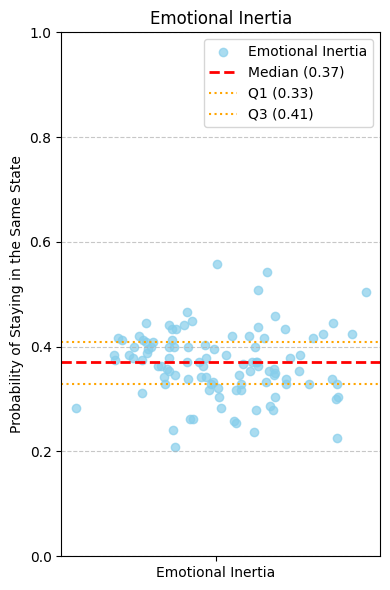

In [15]:
# Run individual functions

emo_reset = calc_emo_reset(emo_seqs)
emo_inertia = calc_inertia(emo_seqs)
#plot_emo_reset(emo_reset)
plot_inertia(emo_inertia)